# P3 Auditory oddball

This builds on the P50 example.

Experimental design

* Stimuli are 2 different auditory tones presented in random order, with higher probability ("standard, .66) and lower probability ("target", .33).

* One tone is higher frequency, the other is lower frequency. There are two blocks of trials, each tone serves as the standard one block, the target in the other.

* The task is to respond to the target tones by pressing a button.

Event code tagging

* The codemap patterns tag the stimulus and response event **sequences** for stimulus type, tone type, and response accuracy.

* EEG quality control flags (log_evcodes > 0) are used to exclude EEG trials prior to analysis

In [1]:
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from mkpy import mkh5
from spudtr import epf

# path wrangling for nbsphinx
if "MDE_HOME" in os.environ.keys():
    MDE_HOME = Path(os.environ["MDE_HOME"])
else:
    from conf import MDE_HOME

In [2]:
%%bash
conda list | egrep "(mkpy|spudtr)"

mkpy                      0.2.3                0_gc7b31fa    kutaslab
spudtr                    0.0.9                g0e166be_0    kutaslab/label/pre-release


**mkh5**  EEG data, event code log, header information

In [3]:
# set filenames
crw = MDE_HOME / "mkdig/sub000p3.crw"    # EEG recording
log = MDE_HOME / "mkdig/sub000p3.x.log"  # events 
yhdr = MDE_HOME / "mkpy/sub000p3.yhdr"   # extra header info

# set calibration data filenames
cals_crw = MDE_HOME / "mkdig/sub000c.crw"
cals_log = MDE_HOME / "mkdig/sub000c.x.log"
cals_yhdr = MDE_HOME / "mkpy/sub000c.yhdr"

# HDF5 file with EEG recording, events, and header
p3_h5_f = MDE_HOME / "data/sub000p3.h5"  
print(p3_h5_f)

# convert to HDF5
p3_h5 = mkh5.mkh5(p3_h5_f)

p3_h5.reset_all()
p3_h5.create_mkdata("sub000", crw, log, yhdr)

# add calibration data
p3_h5.append_mkdata("sub000", cals_crw, cals_log, cals_yhdr)

# calibrate
pts, pulse, lo, hi, ccode = 5, 10, -40, 40, 0
p3_h5.calibrate_mkdata(
    "sub000",  # data group to calibrate with these cal pulses
    n_points=pts,  # pts to average
    cal_size=pulse,  # uV
    lo_cursor=lo,  # lo_cursor ms
    hi_cursor=hi,  # hi_cursor ms
    cal_ccode=ccode,  # condition code
)

/mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.h5


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:3706: UserWarning: negative event code(s) found for cal condition code 0 -16384
  warnings.warn(msg)


Found cals in /sub000/dblock_4
Calibrating block /sub000/dblock_0 of 5: (31232,)  


Calibrating block /sub000/dblock_1 of 5: (32768,)  


Calibrating block /sub000/dblock_2 of 5: (31744,)  


Calibrating block /sub000/dblock_3 of 5: (32512,)  


Calibrating block /sub000/dblock_4 of 5: (28416,)  


**codemap**

In [4]:
%%bash
head -26 ${MDE_HOME}/mkpy/p3_codemap.ytbl

# mkpy YAML codemap
# rows and columns must align, regexp is a mandatory column, all else is whatever.
#
# Note the regular expression negation *NON CAPTURNG* group (?!1040)
# to pattern-match "anything except 1040", i.e., an omitted response,
# as in (#10) (?!1040). Depending on the stimulus type, an ommited
# response is "correct" or "incorrect"

---
name: p3  

columns:
  [regexp,          ccode,  instrument,   bin,    tone,  stim,       accuracy,    acc_type ]
                                  
rows:                             
  - ['(#\d+)',          0,         cal,     0,    cal,    cal,        cal,         cal      ]
  - ['(#11) 1040',      1,         eeg,     3,     hi,    target,     correct,     hit      ]
  - ['(#10) (?!1040)',  1,         eeg,     4,     lo,    standard,   correct,     cr       ]
  - ['(#11) (?!1040)',  1,         eeg,     5,     hi,    target,     incorrect,   miss     ]
  - ['(#10) 1040',      1,         eeg,     6,     lo,    standard,   incorrect,   fa

**1. get_event_table(*codemap*)**

In [5]:
p3_event_table = p3_h5.get_event_table(MDE_HOME / "mkpy/p3_codemap.ytbl")

searching codes in: sub000/dblock_0
searching codes in: sub000/dblock_1
searching codes in: sub000/dblock_2


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1060: UserWarning: 
As of mkpy 0.2.0 to match events with a codemap regexp pattern, the
ccode column in p3_codemap.ytbl must also match the log_ccode
in the datablock. If this behavior is not desired, delete or rename
the ccode column in the codemap.
  warnings.warn(msg)


searching codes in: sub000/dblock_3
searching codes in: sub000/dblock_4


**inspect the event table**

In [6]:
print(p3_event_table.shape)
print(p3_event_table.columns)

# select some columns to show
example_columns = [
    "dblock_path", "dblock_ticks", "log_evcodes", "log_ccodes", "log_flags", 
    "regexp", "match_code", "instrument", "bin", "tone", "stim", "acc_type",
]

# first few stimulus events
display(p3_event_table[example_columns].head())

# last few calibration pulse events
display(p3_event_table[example_columns].tail())

pd.crosstab(
    [
        p3_event_table.instrument, 
        p3_event_table.ccode, 
        p3_event_table.stim, 
        p3_event_table.accuracy,
        p3_event_table.acc_type,
        p3_event_table.tone,
        p3_event_table.bin,
    ],
    [
        p3_event_table.log_flags
    ],
    margins=True
)

(601, 31)
Index(['data_group', 'dblock_path', 'dblock_tick_idx', 'dblock_ticks',
       'crw_ticks', 'raw_evcodes', 'log_evcodes', 'log_ccodes', 'log_flags',
       'epoch_match_tick_delta', 'epoch_ticks', 'dblock_srate', 'match_group',
       'idx', 'dlim', 'anchor_str', 'match_str', 'anchor_code', 'match_code',
       'anchor_tick', 'match_tick', 'anchor_tick_delta', 'is_anchor', 'regexp',
       'ccode', 'instrument', 'bin', 'tone', 'stim', 'accuracy', 'acc_type'],
      dtype='object')


,dblock_path,dblock_ticks,log_evcodes,log_ccodes,log_flags,regexp,match_code,instrument,bin,tone,stim,acc_type
125,sub000/dblock_0,1468,11,1,0,(#11) 1040,11,eeg,3,hi,target,hit
126,sub000/dblock_0,2396,11,1,0,(#11) 1040,11,eeg,3,hi,target,hit
127,sub000/dblock_0,2943,11,1,0,(#11) 1040,11,eeg,3,hi,target,hit
128,sub000/dblock_0,3308,11,1,0,(#11) 1040,11,eeg,3,hi,target,hit
129,sub000/dblock_0,4574,11,1,0,(#11) 1040,11,eeg,3,hi,target,hit


,dblock_path,dblock_ticks,log_evcodes,log_ccodes,log_flags,regexp,match_code,instrument,bin,tone,stim,acc_type
1088,sub000/dblock_4,27315,4,0,0,(#\d+),4,cal,0,cal,cal,cal
1089,sub000/dblock_4,27444,2,0,0,(#\d+),2,cal,0,cal,cal,cal
1090,sub000/dblock_4,27573,3,0,0,(#\d+),3,cal,0,cal,cal,cal
1091,sub000/dblock_4,27703,4,0,0,(#\d+),4,cal,0,cal,cal,cal
1092,sub000/dblock_4,27832,2,0,0,(#\d+),2,cal,0,cal,cal,cal


log_flags                                               0  32  48  64  All
instrument ccode stim     accuracy acc_type tone bin                      
cal        0     cal      cal      cal      cal  0    208   0   0   1  209
eeg        1     standard correct  cr       hi   10   142   3   1   0  146
                                            lo   4    138   7   1   0  146
                 target   correct  hit      hi   3     23  12  15   0   50
                                            lo   9     31  11   8   0   50
All                                                   542  33  25   1  601

**2. set_epochs(name, pre, post)**

Stash the the event table events and tags with a name and epoch interval boundaries.

In [7]:
p3_h5.set_epochs("ms1500", p3_event_table, -750, 750)

Sanitizing event table data types for mkh5 epochs table ...


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (392, b'sub000', b'sub000/dblock_4', 0, 26, 26, 2, 2, 0, 64, 0, 1, 250., 1, 0, 1, b'2', b'2', 2, 2, 26, 26, 0, True, b'(#\\d+)', 0, b'cal', 0, b'cal', b'cal', b'cal', b'cal')
  + "skipping epoch {0}".format(e)


**3. export_epochs(*name*, *file_format=...*)** 

Export the time-stamped, tagged, fixed-length segments of EEG data for analysis as HDF5, pandas HDF5 or feather

In [8]:
p3_h5.export_epochs("ms1500", MDE_HOME / "data/sub000p3.ms1500.epochs.pdh5", file_format="pdh5")        

**analyze the epochs**

* Is there a difference between standard and targets?

* If so, is the effect the same for high and low tone standards and targers?

In [9]:
p3_epochs = pd.read_hdf(MDE_HOME / "data/sub000p3.ms1500.epochs.pdh5", key = "ms1500")
# sanitize Epoch_idx for pandas index
p3_epochs['epoch_id'] = p3_epochs['epoch_id'].astype('int')

# 26 cap + EOG and A2 channel labels
p3_chans = [col for col in p3_epochs.columns if re.match(r"^[MLRAHlr]\w{1,3}$", col)]
print(f"n channels: {len(p3_chans)}\nchannels:{p3_chans}")


# lookup the epochs with stim events at time == 0) and clean artifact flags (= 0)
good_epoch_ids = p3_epochs.query("match_time == 0 and log_flags == 0").epoch_id

# select just the good epochs
p3_epochs = p3_epochs.query("epoch_id in @good_epoch_ids").copy()

# check the good event counts after dropping artifacts
p3_good_events = p3_epochs.query("match_time == 0")

print("After excluding EEG artifacts")
pd.crosstab(
    [
        p3_good_events.instrument, 
        p3_good_events.ccode, 
        p3_good_events.stim, 
        p3_good_events.accuracy,
        p3_good_events.acc_type,
        p3_good_events.tone,
        p3_good_events.bin,
        p3_good_events.log_evcodes,
    ],
    [
        p3_good_events.log_flags
    ],
    margins=True
)



n channels: 32
channels:['lle', 'lhz', 'MiPf', 'LLPf', 'RLPf', 'LMPf', 'RMPf', 'LDFr', 'RDFr', 'LLFr', 'RLFr', 'LMFr', 'RMFr', 'LMCe', 'RMCe', 'MiCe', 'MiPa', 'LDCe', 'RDCe', 'LDPa', 'RDPa', 'LMOc', 'RMOc', 'LLTe', 'RLTe', 'LLOc', 'RLOc', 'MiOc', 'A2', 'HEOG', 'rle', 'rhz']


After excluding EEG artifacts


log_flags                                                           0  All
instrument ccode stim     accuracy acc_type tone bin log_evcodes          
cal        0     cal      cal      cal      cal  0   1             49   49
                                                     2             47   47
                                                     3             56   56
                                                     4             56   56
eeg        1     standard correct  cr       hi   10  20           142  142
                                            lo   4   10           138  138
                 target   correct  hit      hi   3   11            23   23
                                            lo   9   21            31   31
All                                                               542  542

In [10]:
# for illustration ... 
midline = ["MiPf", "MiCe", "MiPa", "MiOc"]

# select COLUMNS: epoch index, timestamps, event tags, and midline EEG columns
midline_epochs = p3_epochs[["epoch_id", "match_time", "stim", "tone"] + midline]

# select ROWS: use tag values to pick and choose
midline_epochs = midline_epochs.query("stim in ['standard', 'target']")

# center each channel 
midline_epochs = epf.center_eeg(
    midline_epochs, 
    midline, 
    -750, 0, 
    epoch_id="epoch_id", 
    time="match_time"
)

**time-domain average midline ERPs**

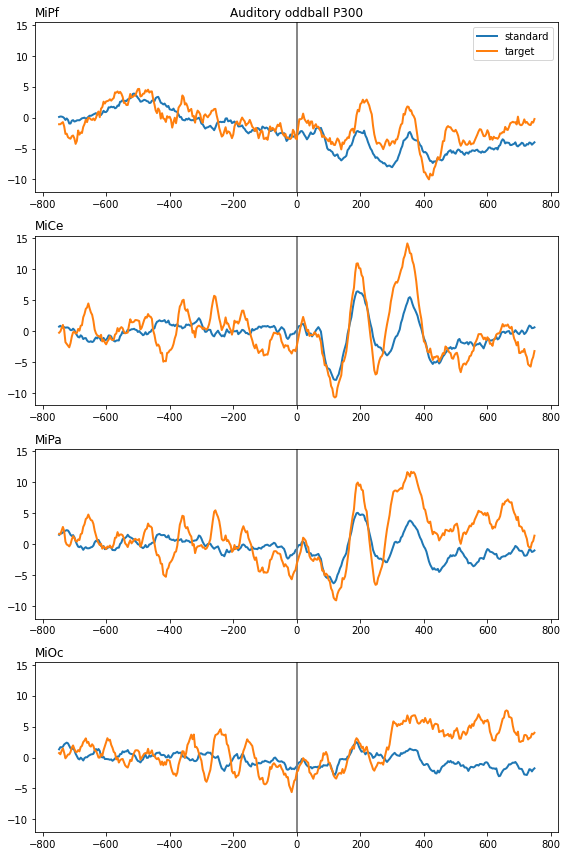

In [11]:
# compute domain average by stim type
midline_erps = midline_epochs.groupby(
    ["stim", "match_time"]
).mean().reset_index()

# plot
f, axs = plt.subplots(4, 1, figsize=(8,12), sharey=True)

for (stim), erp in midline_erps.groupby(['stim']):
    for axi, chan in enumerate(midline):
        
        # mark onset
        axs[axi].axvline(0, color='gray')
        
        axs[axi].plot(
            erp["match_time"],
            erp[chan],
            label=f"{stim}",
            lw=2,
        )
        
        # channel
        axs[axi].set_title(chan, loc='left')

axs[0].legend()
axs[0].set_title("Auditory oddball P300")
f.tight_layout()


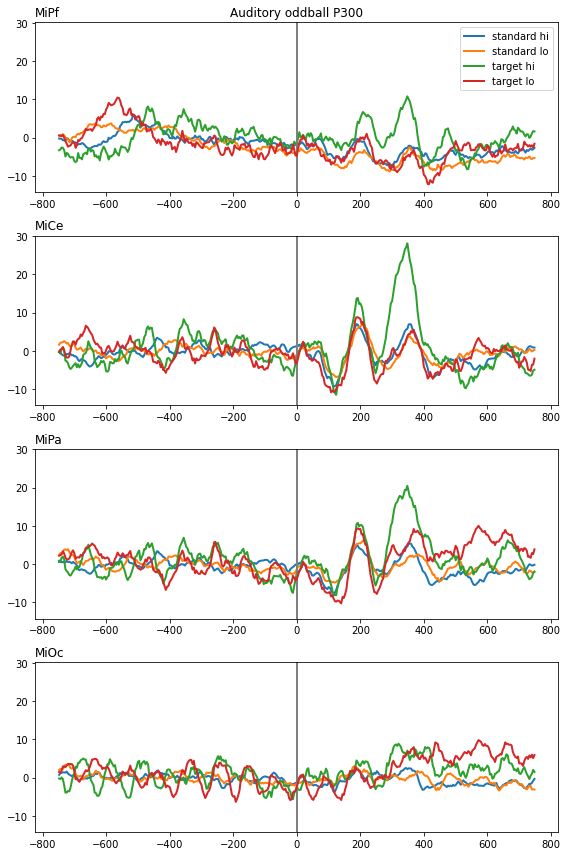

In [12]:
# average by stim type
midline_erps = midline_epochs.groupby(["stim", "tone", "match_time"]).mean().reset_index()

# plot
f, axs = plt.subplots(4, 1, figsize=(8,12), sharey=True)

for (stim, tone), erp in midline_erps.groupby(['stim', "tone"]):
    for axi, chan in enumerate(midline):
        
        # mark onset
        axs[axi].axvline(0, color='gray')
        
        axs[axi].plot(
            erp["match_time"],
            erp[chan],
            label=f"{stim} {tone}",
            lw=2,
        )
        
        # channel
        axs[axi].set_title(chan, loc='left')

axs[0].legend()
axs[0].set_title("Auditory oddball P300")
f.tight_layout()
    

**Single subject pipeline with epoch export in different formats**

build and calibrate the mkpy HDF5 format data file

1. get_event_table(*codemap*)
2. set_epoch_table(*name*, *pre*, "post*)
3. export_epochs(*name*, *file_format=...*)

In [13]:
# build mkpy.mkh5 format data file and calibrate
p3_h5 = mkh5.mkh5(p3_h5_f)
p3_h5.reset_all()
p3_h5.create_mkdata("sub000", crw, log, yhdr)

p3_h5.append_mkdata("sub000", cals_crw, cals_log, cals_yhdr)

pts, pulse, lo, hi, ccode = 5, 10, -40, 40, 0
p3_h5.calibrate_mkdata(
    "sub000",  
    n_points=pts,
    cal_size=pulse,
    lo_cursor=lo,
    hi_cursor=hi,
    cal_ccode=ccode,
)


# 1. scan events into the event table 
p3_event_table = p3_h5.get_event_table(MDE_HOME / "mkpy/p3_codemap.ytbl")


# define epoch names and intervals 
epoch_specs  = {
    "ms100": (-50, 50),
    "ms1500": (-750, 750),
    "ms3000": (-1500, 1500),
    "ms10000": (-5000, 5000),
}

for epoch_name, (pre, post) in epoch_specs.items():
    print(epoch_name, pre, post)

    # 2. set the epoch specs
    p3_h5.set_epochs(epoch_name, p3_event_table, pre, post)
    
    # multiple export formats for demonstration, in practice pick one format
    fformats = ["h5", "pdh5", "feather"]
    for ffmt in fformats:
        
        _fname = f"{MDE_HOME}/data/sub000p3.{epoch_name}.epochs.{ffmt}"
        print(f"exporting p3 {epoch_name} as {ffmt}: {_fname}")
        
        # 3. this exports the epochs DATA ... EEG and events.
        p3_h5.export_epochs(epoch_name, _fname, file_format=ffmt)
        

/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:3706: UserWarning: negative event code(s) found for cal condition code 0 -16384
  warnings.warn(msg)


Found cals in /sub000/dblock_4
Calibrating block /sub000/dblock_0 of 5: (31232,)  


Calibrating block /sub000/dblock_1 of 5: (32768,)  


Calibrating block /sub000/dblock_2 of 5: (31744,)  


Calibrating block /sub000/dblock_3 of 5: (32512,)  


Calibrating block /sub000/dblock_4 of 5: (28416,)  


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1060: UserWarning: 
As of mkpy 0.2.0 to match events with a codemap regexp pattern, the
ccode column in p3_codemap.ytbl must also match the log_ccode
in the datablock. If this behavior is not desired, delete or rename
the ccode column in the codemap.
  warnings.warn(msg)


searching codes in: sub000/dblock_0
searching codes in: sub000/dblock_1
searching codes in: sub000/dblock_2
searching codes in: sub000/dblock_3
searching codes in: sub000/dblock_4


ms100 -50 50


Sanitizing event table data types for mkh5 epochs table ...


exporting p3 ms100 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms100.epochs.h5


exporting p3 ms100 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms100.epochs.pdh5


exporting p3 ms100 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms100.epochs.feather


ms1500 -750 750


Sanitizing event table data types for mkh5 epochs table ...


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (392, b'sub000', b'sub000/dblock_4', 0, 26, 26, 2, 2, 0, 64, 0, 1, 250., 1, 0, 1, b'2', b'2', 2, 2, 26, 26, 0, True, b'(#\\d+)', 0, b'cal', 0, b'cal', b'cal', b'cal', b'cal')
  + "skipping epoch {0}".format(e)


exporting p3 ms1500 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms1500.epochs.h5


exporting p3 ms1500 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms1500.epochs.pdh5


exporting p3 ms1500 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms1500.epochs.feather


ms3000 -1500 1500


Sanitizing event table data types for mkh5 epochs table ...


exporting p3 ms3000 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms3000.epochs.h5


exporting p3 ms3000 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms3000.epochs.pdh5


exporting p3 ms3000 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms3000.epochs.feather


ms10000 -5000 5000


Sanitizing event table data types for mkh5 epochs table ...


/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (27, b'sub000', b'sub000/dblock_0', 0, 943, 943, 10, 10, 1, 0, 0, 1, 250., 1, 0, 1, b'10', b'10', 10, 10, 943, 943, 0, True, b'(#10) (?!1040)', 1, b'eeg', 4, b'lo', b'standard', b'correct', b'cr')
  + "skipping epoch {0}".format(e)
/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (28, b'sub000', b'sub000/dblock_0', 1, 1212, 1212, 10, 10, 1, 0, 0, 1, 250., 1, 1, 4, b'10', b'10', 10, 10, 1212, 1212, 0, True, b'(#10) (?!1040)', 1, b'eeg', 4, b'lo', b'standard', b'correct', b'cr')
  + "skipping epoch {0}".format(e)
/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1520: UserWarning: data error: post-stimulus interval is out o

/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (196, b'sub000', b'sub000/dblock_2', 1, 857, 64857, 21, 21, 1, 32, 0, 1, 250., 1, 1, 4, b'21', b'21', 21, 21, 857, 857, 0, True, b'(#21) 1040', 1, b'eeg', 9, b'lo', b'target', b'correct', b'hit')
  + "skipping epoch {0}".format(e)
/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of bounds left ... skipping epoch (197, b'sub000', b'sub000/dblock_2', 3, 1194, 65194, 21, 21, 1, 32, 0, 1, 250., 1, 3, 12, b'21', b'21', 21, 21, 1194, 1194, 0, True, b'(#21) 1040', 1, b'eeg', 9, b'lo', b'target', b'correct', b'hit')
  + "skipping epoch {0}".format(e)
/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1514: UserWarning: data error: pre-stimulus interval is out of b

/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1520: UserWarning: data error: post-stimulus interval is out of bounds right ... skipping epoch (389, b'sub000', b'sub000/dblock_3', 120, 31379, 127123, 20, 20, 1, 0, 0, 1, 250., 1, 120, 411, b'20', b'20', 20, 20, 31379, 31379, 0, True, b'(#20) (?!1040)', 1, b'eeg', 10, b'hi', b'standard', b'correct', b'cr')
  + "skipping epoch {0}".format(e)
/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1520: UserWarning: data error: post-stimulus interval is out of bounds right ... skipping epoch (390, b'sub000', b'sub000/dblock_3', 121, 31708, 127452, 20, 20, 1, 0, 0, 1, 250., 1, 121, 414, b'20', b'20', 20, 20, 31708, 31708, 0, True, b'(#20) (?!1040)', 1, b'eeg', 10, b'hi', b'standard', b'correct', b'cr')
  + "skipping epoch {0}".format(e)
/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1520: UserWarning: data erro

/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1520: UserWarning: data error: post-stimulus interval is out of bounds right ... skipping epoch (595, b'sub000', b'sub000/dblock_4', 203, 27186, 27186, 1, 1, 0, 0, 0, 1, 250., 1, 203, 407, b'1', b'1', 1, 1, 27186, 27186, 0, True, b'(#\\d+)', 0, b'cal', 0, b'cal', b'cal', b'cal', b'cal')
  + "skipping epoch {0}".format(e)
/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1520: UserWarning: data error: post-stimulus interval is out of bounds right ... skipping epoch (596, b'sub000', b'sub000/dblock_4', 204, 27315, 27315, 4, 4, 0, 0, 0, 1, 250., 1, 204, 409, b'4', b'4', 4, 4, 27315, 27315, 0, True, b'(#\\d+)', 0, b'cal', 0, b'cal', b'cal', b'cal', b'cal')
  + "skipping epoch {0}".format(e)
/home/turbach/miniconda3/envs/mkconda_for_sphinxdocs/lib/python3.6/site-packages/mkpy/mkh5.py:1520: UserWarning: data error: post-stimulus interval is out of bounds r

exporting p3 ms10000 as h5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms10000.epochs.h5


exporting p3 ms10000 as pdh5: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms10000.epochs.pdh5


exporting p3 ms10000 as feather: /mnt/cube/home/turbach/TPU_Projects/mkpy_data_examples/data/sub000p3.ms10000.epochs.feather
